In [ ]:
!nohub

In [1]:
!nohup pip install wrapt --upgrade --ignore-installed
!nohup pip install tensorflow

nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’


In [38]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_treebank_pos_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [1]:
# NLP
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Classification
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

# Regression Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.metrics import AUC, BinaryAccuracy, Recall, Precision
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Testing and optimization
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.metrics.regression import mean_absolute_error, mean_squared_error, r2_score

# import module
from pipeline import *
from model import *

# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   
import pickle
import datetime as dt
import glob

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")


ModuleNotFoundError: No module named 'sagemaker'

In [9]:
# read csv from s3 bucket
s3 = boto3.resource('s3')
bucket = 'fakenewscorpus'
key = 'data/news_cleaned_2018_02_13.csv'
demo = pd.read_csv('s3://{}/{}'.format(bucket,key), engine = 'python', nrows = 100000)

In [16]:
demo.to_pickle('../data/demo_df.pkl')

In [44]:
# load cleaned demo_df
demo = pd.read_pickle('../data/demo_df.pkl')

In [41]:
sw = pd.read_csv('../data/sw1k.csv')['term'].to_numpy()

In [42]:
demo = clean(demo)

KeyError: "['id' 'Unnamed: 0' 'domain' 'url' 'scraped_at' 'inserted_at' 'updated_at'\n 'keywords' 'meta_description' 'meta_keywords' 'tags' 'summary' 'source'] not found in axis"

In [43]:
demo['token'] = cleanText(demo['content'])

KeyboardInterrupt: 

In [45]:
cv = CountVectorizer(max_features = 500)
tv = TfidfVectorizer(max_features = 500)

# demo['token']=tokenize(demo['content'],sw)
# tv = TfidfVectorizer(demo['content'], max_features = 500)

In [46]:
X = demo['content']
y = demo['label']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [47]:
X_train = tv.fit_transform(X_train)
pickle.dump(tv, open("demo_tv.pickle", "wb"))

In [48]:
X_test = tv.transform(X_test)

In [49]:
demo_model = Sequential()
 
demo_model.add(Dense(units=100, activation='relu', input_dim=500))
demo_model.add(Dense(units=1, activation='sigmoid'))
 
demo_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC','BinaryAccuracy','Recall','Precision'])
demo_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 50,201
Trainable params: 50,201
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = demo_model.fit(X_train, y_train, 
          epochs=15, batch_size=128, verbose=1,
          validation_split=0.20)

Train on 39228 samples, validate on 9807 samples
Epoch 1/15
39228/39228 [==============================] - 1s 19us/sample - loss: 0.0800 - auc_2: 0.9952 - binary_accuracy: 0.9716 - recall_2: 0.9511 - precision_2: 0.9921 - val_loss: 0.1306 - val_auc_2: 0.9844 - val_binary_accuracy: 0.9537 - val_recall_2: 0.9303 - val_precision_2: 0.9749
Epoch 2/15
39228/39228 [==============================] - 1s 19us/sample - loss: 0.0760 - auc_2: 0.9958 - binary_accuracy: 0.9740 - recall_2: 0.9553 - precision_2: 0.9927 - val_loss: 0.1363 - val_auc_2: 0.9839 - val_binary_accuracy: 0.9538 - val_recall_2: 0.9190 - val_precision_2: 0.9867
Epoch 3/15
39228/39228 [==============================] - 1s 19us/sample - loss: 0.0718 - auc_2: 0.9964 - binary_accuracy: 0.9750 - recall_2: 0.9564 - precision_2: 0.9936 - val_loss: 0.1317 - val_auc_2: 0.9845 - val_binary_accuracy: 0.9541 - val_recall_2: 0.9357 - val_precision_2: 0.9705
Epoch 4/15
39228/39228 [==============================] - 1s 19us/sample - loss: 0.0

In [71]:
demo_model.save('../saved_model/demo_model')

In [57]:
demo_model.evaluate(X_test, y_test)

16346/16346 [==============================] - 1s 34us/sample - loss: 0.1291 - auc_2: 0.9862 - binary_accuracy: 0.9612 - recall_2: 0.9376 - precision_2: 0.9847


[0.12910693261039005, 0.986183, 0.96121377, 0.9376062, 0.9847017]

In [55]:
def plot_history(history, metric):
# Plot training & validation accuracy values
    plt.plot(history.history[metric])
    plt.plot(history.history['val_{}'.format(metric)])
    plt.title('Model {}'.format(metric), size = 32)
    plt.ylabel('{}'.format(metric))
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

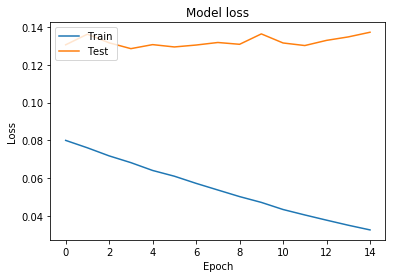

In [56]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
X_demo = 'The new coronavirus is rapidly spreading around the world, reaching every continent except Antarctica. As of March 2, there have been more than 80,000 illnesses reported in China, and more than 8,700 illnesses reported outside of mainland China in 64 countries, according to the World Health Organization. Large outbreaks have been reported in South Korea, Italy and Iran, and there are a growing number of cases in Europe and the United States.'

In [13]:
def demo_detector(article, tv, model):
    demo = tv.transform([article])
    demo = demo.todense()
    if model.predict(demo) <= 0.5:
        print('This article is non-fake.')
    else:
        print('This article is fake.')

In [14]:
demo_detector(X_demo, demo_tv, model)

This article is non-fake.


In [69]:
X_demo2 = tv.transform(list(demo['content'].head(1)))

In [70]:
demo_model.predict(X_demo2)

array([[0.9179284]], dtype=float32)

In [2]:
model = load_model('../saved_model/demo_model')

In [3]:
demo_tv = pickle.load(open("demo_tv.pickle", "rb"))

//anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
